In [ ]:
# Import necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from time import time

# Setting a seed for reproducibility
np.random.seed(10)

# Load and prepare training data
exp_data_tr = pd.read_csv('DC_Motor_experimental_data_training.csv')
exp_data_tr.columns = ['time', 'voltage', 'speed']

t_tr = np.array(exp_data_tr["time"])
v_tr = np.array(exp_data_tr["voltage"])
theta_tr = np.array(exp_data_tr["speed"])

# Stack the input features: theta (speed) and v (voltage)
X_tr = np.column_stack((theta_tr, v_tr))

# Create polynomial features to mimic the behavior of feature libraries in PySINDy
poly = PolynomialFeatures(degree=3, include_bias=False)
X_tr_poly = poly.fit_transform(X_tr)

# Initialize the models
models = {
    "OLS (Linear Regression)": LinearRegression(),
    "Lasso": Lasso(alpha=0.1, max_iter=200),
    "Ridge": Ridge(alpha=1.0),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "SVR": SVR(),
    "K-Nearest Neighbors": KNeighborsRegressor(n_neighbors=5),
    "Gradient Boosting": GradientBoostingRegressor(n_estimators=100)
}

# Dictionary to store predictions and metrics
predictions = {}
metrics = {}

# Train each model and store predictions and metrics
for name, model in models.items():
    # Start timer
    t0 = time()

    # Train the model
    model.fit(X_tr_poly, theta_tr)

    # Print computation time
    print(f'{name} Computation time: {time() - t0} seconds')

    # Store coefficients and intercept if available
    intercept = getattr(model, 'intercept_', None)
    coefficients = getattr(model, 'coef_', None)
    features = poly.get_feature_names_out()

    if intercept is not None and coefficients is not None:
        # Create model equation
        equation = f"{intercept:.4f}"
        for feature, coef in zip(features, coefficients):
            equation += f" + ({coef:.4f})*{feature}"
        print(f"\n{name} Model (Equation): theta = {equation}\n")
    else:
        print(f"\n{name} does not provide a simple linear equation.\n")

    # Predict on the test data
    X_ts_poly = poly.transform(np.column_stack((theta_tr, v_tr)))
    predictions[name] = model.predict(X_ts_poly)

    # Calculate evaluation metrics
    mse = mean_squared_error(theta_tr, predictions[name])
    mae = mean_absolute_error(theta_tr, predictions[name])
    r2 = r2_score(theta_tr, predictions[name])

    # Store metrics
    metrics[name] = {'MSE': mse, 'MAE': mae, 'R2': r2}


OLS (Linear Regression) Computation time: 0.0072782039642333984 seconds

OLS (Linear Regression) Model (Equation): theta = 0.0000 + (1.0000)*x0 + (-0.0000)*x1 + (0.0000)*x0^2 + (-0.0000)*x0 x1 + (0.0000)*x1^2 + (-0.0000)*x0^3 + (0.0000)*x0^2 x1 + (-0.0000)*x0 x1^2 + (0.0000)*x1^3

Lasso Computation time: 0.008291006088256836 seconds

Lasso Model (Equation): theta = 0.0039 + (1.0000)*x0 + (0.0000)*x1 + (0.0000)*x0^2 + (-0.0000)*x0 x1 + (-0.0000)*x1^2 + (0.0000)*x0^3 + (-0.0000)*x0^2 x1 + (-0.0000)*x0 x1^2 + (-0.0000)*x1^3

Ridge Computation time: 0.01400899887084961 seconds

Ridge Model (Equation): theta = 0.0058 + (0.9999)*x0 + (-0.0000)*x1 + (0.0000)*x0^2 + (0.0000)*x0 x1 + (-0.0000)*x1^2 + (-0.0000)*x0^3 + (-0.0000)*x0^2 x1 + (0.0000)*x0 x1^2 + (0.0000)*x1^3

Decision Tree Computation time: 0.3752906322479248 seconds

Decision Tree does not provide a simple linear equation.

Random Forest Computation time: 22.103095531463623 seconds

Random Forest does not provide a simple linear equ

OLS (Linear Regression) Test Set Mean Squared Error (MSE): 1.6416349315563558e-24
OLS (Linear Regression) Test Set Mean Absolute Error (MAE): 1.2226740798544522e-12
OLS (Linear Regression) Test Set R^2 Score: 1.0

Lasso Test Set Mean Squared Error (MSE): 1.677200926568248e-07
Lasso Test Set Mean Absolute Error (MAE): 0.00023564733827709312
Lasso Test Set R^2 Score: 0.999999999964565

Ridge Test Set Mean Squared Error (MSE): 6.805242045683962e-09
Ridge Test Set Mean Absolute Error (MAE): 5.278644051718803e-05
Ridge Test Set R^2 Score: 0.9999999999985623

Decision Tree Test Set Mean Squared Error (MSE): 0.028857051890021662
Decision Tree Test Set Mean Absolute Error (MAE): 0.03801494983224895
Decision Tree Test Set R^2 Score: 0.9999939032328798

Random Forest Test Set Mean Squared Error (MSE): 0.010413113025053712
Random Forest Test Set Mean Absolute Error (MAE): 0.024292983373413787
Random Forest Test Set R^2 Score: 0.9999977999718976

SVR Test Set Mean Squared Error (MSE): 71.318821122

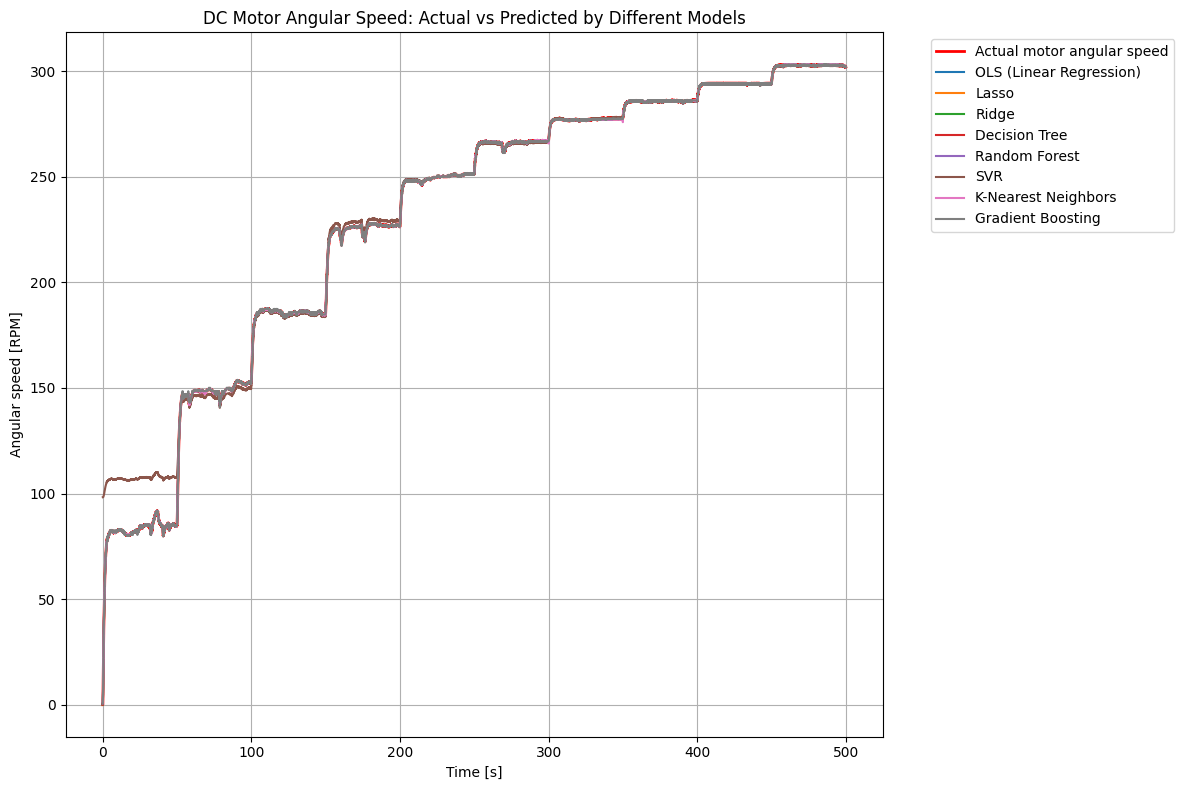

In [ ]:
# Load and prepare testing data
exp_data_ts = pd.read_csv('DC_Motor_experimental_data_testing.csv')
exp_data_ts.columns = ['time', 'voltage', 'speed']

t_ts = np.array(exp_data_ts["time"])
v_ts = np.array(exp_data_ts["voltage"])
theta_ts = np.array(exp_data_ts["speed"])

# Stack the input features for testing data
X_ts = np.column_stack((theta_ts, v_ts))
X_ts_poly = poly.transform(X_ts)

# Evaluate and plot all models
plt.figure(figsize=(12, 8))
plt.plot(t_ts, theta_ts, label='Actual motor angular speed', color='red', linewidth=2)

for name, theta_pred in predictions.items():
    # Re-predict for actual test data
    theta_pred = models[name].predict(X_ts_poly)

    # Calculate and print evaluation metrics for the test set
    mse = mean_squared_error(theta_ts, theta_pred)
    mae = mean_absolute_error(theta_ts, theta_pred)
    r2 = r2_score(theta_ts, theta_pred)

    print(f"{name} Test Set Mean Squared Error (MSE): {mse}")
    print(f"{name} Test Set Mean Absolute Error (MAE): {mae}")
    print(f"{name} Test Set R^2 Score: {r2}\n")

    # Plot predictions
    plt.plot(t_ts, theta_pred, label=f'{name}')

# Final plot adjustments
plt.xlabel('Time [s]')
plt.ylabel('Angular speed [RPM]')
plt.title('DC Motor Angular Speed: Actual vs Predicted by Different Models')
plt.legend(loc='upper left', bbox_to_anchor=(1.05, 1))
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Print all metrics for the training set
print("\nEvaluation Metrics for the Training Set:\n")
for name, metric in metrics.items():
    print(f"{name}:")
    print(f" - Mean Squared Error (MSE): {metric['MSE']}")
    print(f" - Mean Absolute Error (MAE): {metric['MAE']}")
    print(f" - R^2 Score: {metric['R2']}\n")



Evaluation Metrics for the Training Set:

OLS (Linear Regression):
 - Mean Squared Error (MSE): 1.5837433156859618e-24
 - Mean Absolute Error (MAE): 1.1833621971688663e-12
 - R^2 Score: 1.0

Lasso:
 - Mean Squared Error (MSE): 1.4297212001476858e-07
 - Mean Absolute Error (MAE): 0.00022661656294867442
 - R^2 Score: 0.9999999999681831

Ridge:
 - Mean Squared Error (MSE): 4.385998578960165e-09
 - Mean Absolute Error (MAE): 3.991575100164128e-05
 - R^2 Score: 0.9999999999990239

Decision Tree:
 - Mean Squared Error (MSE): 4.372175004968759e-13
 - Mean Absolute Error (MAE): 1.8910007581780518e-08
 - R^2 Score: 0.9999999999999999

Random Forest:
 - Mean Squared Error (MSE): 0.00020145020506448594
 - Mean Absolute Error (MAE): 0.0017508763133633272
 - R^2 Score: 0.9999999551694873

SVR:
 - Mean Squared Error (MSE): 55.87914541251298
 - Mean Absolute Error (MAE): 2.8433416601612915
 - R^2 Score: 0.9875647148486989

K-Nearest Neighbors:
 - Mean Squared Error (MSE): 0.0014841285353372207
 - Me